<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



**Shkarbanenko Mikhail**
**Telegram https://t.me/IInfiniteTsukuyomi**
**Stepik ID 537953169**

В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [27]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder, DatasetFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from PIL import Image

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [28]:
DATA_PATH = '/kaggle/input'
IMAGE_SIZE = 128
BATCH_SIZE = 16
LATENT_SIZE = 128
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [29]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [30]:
def get_dataloader(data_path=DATA_PATH, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, device=DEVICE):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    dataset = ImageFolder(data_path, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    return dataset, DeviceDataLoader(dataloader, device)

In [31]:
dataset, dataloader = get_dataloader()

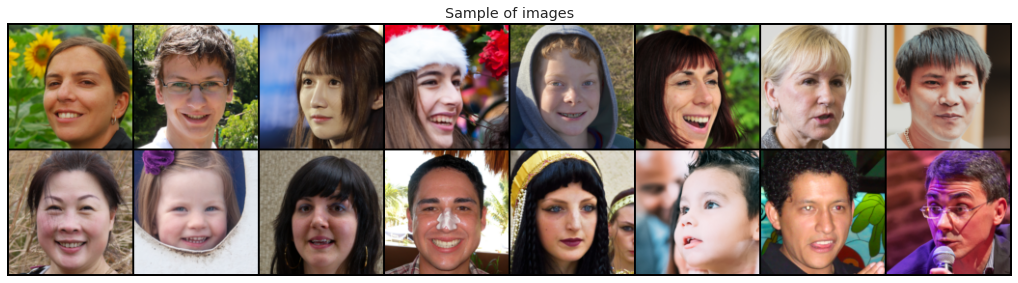

In [32]:
sample, _ = next(iter(dataloader))
plt.figure(figsize=(18, 12))
plt.axis("off")
plt.title("Sample of images")
plt.imshow(make_grid(sample, padding=2, normalize=True).permute(1, 2, 0).cpu().numpy());

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [33]:
discriminator = nn.Sequential(
    
    # in: 3 x 128 x 128
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 32 x 64 x 64
    
    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
    # out: 1 x 1 x 1
)

In [34]:
discriminator.to(DEVICE)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  

In [35]:
generator = nn.Sequential(
    
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(LATENT_SIZE, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(inplace=True),
    # out: 1028 x 4 x 4
    
    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    # out: 512 x 8 x 8
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

In [36]:
generator.to(DEVICE)

Sequential(
  (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [37]:
def fit(dataloader, model, optimizer, criterion, epochs, device=DEVICE, latent_size=LATENT_SIZE):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(dataloader):
            batch_size = real_images.size(0)
            
            # Train discriminator
            optimizer["discriminator"].zero_grad()
            # Pass real images through discriminator
            noise = 0.05 * torch.rand(batch_size, 1, device=device)
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(batch_size, 1, device=device) - noise
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(batch_size, 1, device=device) + noise
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()
            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch + 1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
    return losses_g, losses_d, real_scores, fake_scores

In [38]:
def predict(model, mode, data_batch=None, latent_batch=None, device=DEVICE):
    """Discriminator and Generator forward pass."""
    torch.cuda.empty_cache()
    discriminator = model["discriminator"].eval()
    generator = model["generator"].eval()
    disc_pred, gen_pred = None, None 
    with torch.no_grad():
        if mode == 'discriminator':
            disc_pred = discriminator(data_batch.to(device)).detach().cpu()
            return disc_pred
        elif mode == 'generator':
            gen_pred = generator(latent_batch.to(device)).detach().cpu()
            return gen_pred
        else:
            disc_pred = discriminator(data_batch.to(device)).detach().cpu()
            gen_pred = generator(latent_batch.to(device)).detach().cpu()
            return {"dicriminator": disc_pred, "generator": gen_pred}

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [39]:
LR = 3e-4
NUM_EPOCHS = 25

model = {
    "discriminator": discriminator,
    "generator": generator
}

optimizer = {
    "discriminator": torch.optim.Adam(model["discriminator"].parameters(), lr=LR, betas=(0.5, 0.999)),
    "generator": torch.optim.Adam(model["generator"].parameters(), lr=LR, betas=(0.5, 0.999))
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

losses_g, losses_d, real_scores, fake_scores = fit(dataloader, model, optimizer, criterion, NUM_EPOCHS)

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 6.3330, loss_d: 0.7644, real_score: 0.8132, fake_score: 0.2054


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 3.3033, loss_d: 1.0010, real_score: 0.7030, fake_score: 0.2824


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 1.9469, loss_d: 1.2217, real_score: 0.6069, fake_score: 0.3882


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 1.8834, loss_d: 1.2177, real_score: 0.6042, fake_score: 0.3943


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 1.8842, loss_d: 1.2674, real_score: 0.5877, fake_score: 0.4115


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 2.0266, loss_d: 1.2079, real_score: 0.6006, fake_score: 0.3964


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 1.8594, loss_d: 1.2511, real_score: 0.5882, fake_score: 0.4113


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 2.0261, loss_d: 1.2188, real_score: 0.5985, fake_score: 0.3993


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 2.2182, loss_d: 1.1349, real_score: 0.6225, fake_score: 0.3728


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 2.3203, loss_d: 1.1244, real_score: 0.6293, fake_score: 0.3688


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 2.4960, loss_d: 1.0756, real_score: 0.6477, fake_score: 0.3492


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 2.4029, loss_d: 1.0958, real_score: 0.6446, fake_score: 0.3542


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 2.4209, loss_d: 1.0564, real_score: 0.6569, fake_score: 0.3407


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 2.4450, loss_d: 1.0273, real_score: 0.6678, fake_score: 0.3307


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 2.6140, loss_d: 0.9756, real_score: 0.6832, fake_score: 0.3152


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 2.4449, loss_d: 0.9897, real_score: 0.6826, fake_score: 0.3145


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 2.6500, loss_d: 0.9286, real_score: 0.7009, fake_score: 0.2985


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 2.6869, loss_d: 0.9303, real_score: 0.7048, fake_score: 0.2924


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 2.6711, loss_d: 0.8778, real_score: 0.7202, fake_score: 0.2782


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 2.8853, loss_d: 0.8451, real_score: 0.7326, fake_score: 0.2656


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 2.8050, loss_d: 0.8365, real_score: 0.7372, fake_score: 0.2602


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 2.7806, loss_d: 0.8361, real_score: 0.7439, fake_score: 0.2566


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 2.7842, loss_d: 0.8328, real_score: 0.7426, fake_score: 0.2542


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 2.7896, loss_d: 0.7547, real_score: 0.7637, fake_score: 0.2353


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 2.8921, loss_d: 0.7499, real_score: 0.7686, fake_score: 0.2285


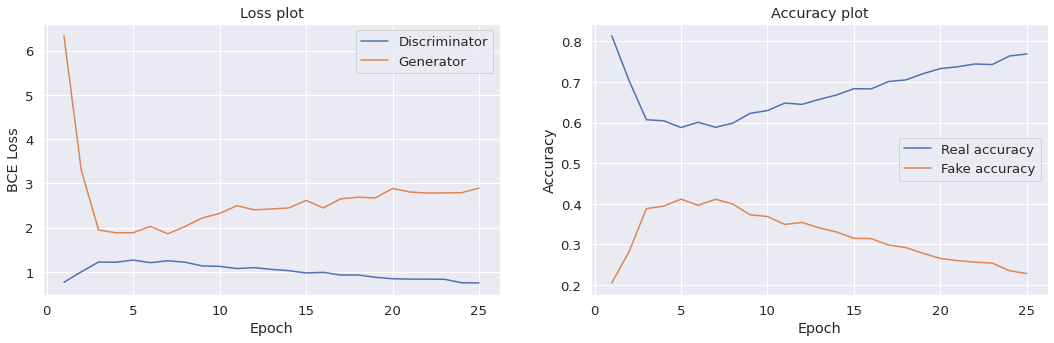

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
epochs_axis = [epoch for epoch in range(1, NUM_EPOCHS + 1)]
axs[0].plot(epochs_axis, losses_d, label='Discriminator')
axs[0].plot(epochs_axis, losses_g, label='Generator')
axs[0].set_title('Loss plot')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('BCE Loss')
axs[0].legend()
axs[1].plot(epochs_axis, real_scores, label='Real accuracy')
axs[1].plot(epochs_axis, fake_scores, label='Fake accuracy')
axs[1].set_title('Accuracy plot')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.show()

**Графики лосов и accuracy соответствуют тем, что были показаны на лекции.**

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [41]:
def show_images(data, figsize, title=None):
    """
    Show sample of images.
    """
    plt.figure(figsize=figsize)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.imshow(make_grid(data, padding=2, normalize=True).permute(1, 2, 0).cpu().numpy());

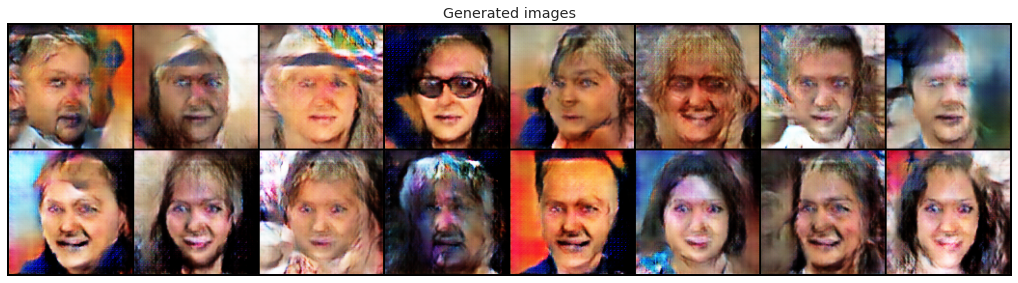

In [42]:
latent_sample = torch.randn(16, LATENT_SIZE, 1, 1, device=DEVICE)
fake_images = predict(model, mode='generator', latent_batch=latent_sample)
show_images(fake_images, figsize=(18,12), title='Generated images')

Как вам качество получившихся изображений?

**Качество сгенерированных изображений неплохое, четко просматриваются черты лица, но много артефактов. Также просматриваются паттерны одного и того же лица. Я добавил шум, как было показано на лекции, чтобы в какой-то степени решить эту проблему, но это не помогло в полной мере.**

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.manifold import TSNE

In [44]:
num_images = len(dataset)
Y_real = np.ones(num_images)
Y_gen = np.zeros(num_images)
Y = np.concatenate((Y_real, Y_gen), axis=0)
X_real = np.array([image.flatten().numpy() for image, _ in dataset])
X_latent = torch.randn(num_images, LATENT_SIZE, 1, 1, device=DEVICE)
X_gen = predict(model, mode='generator', latent_batch=X_latent)
X_gen = np.array([image.flatten().numpy() for image in X_gen])
X = np.concatenate((X_real, X_gen), axis=0)

In [45]:
shuffled_indices = np.random.permutation(2*num_images)
X = X[shuffled_indices]
Y = Y[shuffled_indices]

In [46]:
sample_size = 1000
X_sample = X[:sample_size]
Y_sample = Y[:sample_size]
accuracy = cross_val_score(KNeighborsClassifier(n_neighbors=1), X_sample, Y_sample, cv=LeaveOneOut()).mean()
print(f"accuracy: {accuracy}")

accuracy: 0.836


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

**В идеале нужно получить accuracy = 50%. Это будет значить, что классификатор не может отличить сгенерированные изображения от реальных. Для оценки качества я использовал случайный сэмпл из датасета размером 1000, так как на всем датасете классификатор работает очень долго. Я получил accuracy = 83.6%. Это не очень хороший, но вполне ожидаемый результат. Понятно, что сгенерированные изображения далеки от идеала, но все таки похожи на лица.**

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [47]:
X_embedded = TSNE(n_components=2).fit_transform(X)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


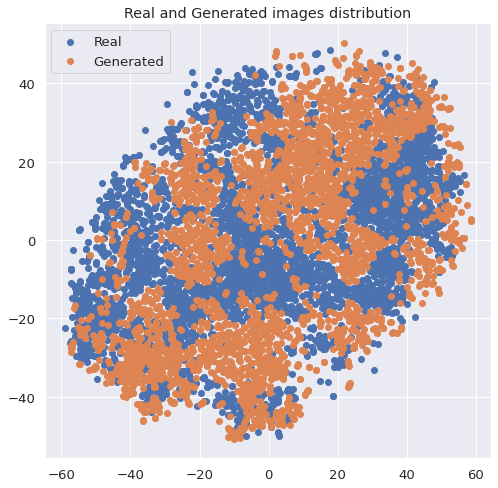

In [48]:
real_img_indices = [idx for idx, label in enumerate(Y) if label == 1]
gen_img_indices = [idx for idx, label in enumerate(Y) if label == 0]
Y_r = Y[real_img_indices]
Y_g = Y[gen_img_indices]
X_embedded_r = X_embedded[real_img_indices]
X_embedded_g = X_embedded[gen_img_indices]
plt.figure(figsize=(8,8))
plt.scatter(X_embedded_r[:, 0], X_embedded_r[:, 1], label='Real')
plt.scatter(X_embedded_g[:, 0], X_embedded_g[:, 1], label='Generated')
plt.legend()
plt.title('Real and Generated images distribution')
plt.show()

Прокомментируйте получившийся результат:

**Как и ожидалось, реальные и сгенерированные изображения локализовались в одной и той же области пространства, но классы все же различить можно. Вектора сгенерированных изображений распределены в определнных областях более густо, а в других почти отсутствуют.**